In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import warnings

import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np
import math
from chainer import cuda, training, reporter, Variable
from chainer.training import trainer, extensions
from chainer import datasets
from chainer.dataset import convert
from chainer.dataset import iterator as iterator_module
from chainer import optimizer as optimizer_module
from chainer import iterators
from chainer import optimizers

warnings.filterwarnings('ignore')
%matplotlib inline
device = 0

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#bring in the six packs
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
test_ID = df_test['Id']
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

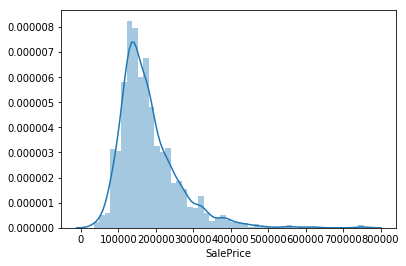

In [6]:
sns.distplot(df_train['SalePrice'])

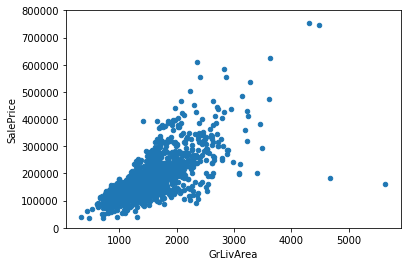

In [7]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

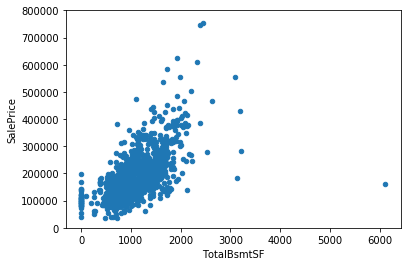

In [8]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [9]:
# string label to categorical values
from sklearn.preprocessing import LabelEncoder

for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(df_train.iloc[:,i].values) + list(df_test.iloc[:,i].values))
        df_train.iloc[:,i] = lbl.transform(list(df_train.iloc[:,i].values))
        df_test.iloc[:,i] = lbl.transform(list(df_test.iloc[:,i].values))

In [10]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000


In [11]:
corrmat = df_train.corr()
corrmat

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,1.000000,0.011156,-0.006096,-0.010601,-0.033226,0.008916,-0.001530,0.032122,-0.019659,0.013324,...,0.057044,-0.033928,-0.000399,0.037057,-0.006242,0.021172,0.000712,0.019773,-0.005806,-0.021917
MSSubClass,0.011156,1.000000,0.035900,-0.386347,-0.139781,-0.024969,-0.105995,0.119289,-0.002940,-0.022844,...,0.008283,-0.005221,0.086360,0.034859,-0.007683,-0.013585,-0.021407,0.012464,-0.024940,-0.084284
MSZoning,-0.006096,0.035900,1.000000,-0.111690,-0.034452,0.087654,-0.052039,0.061887,-0.017854,-0.001192,...,-0.003128,0.002882,-0.061289,0.000673,0.009293,-0.031496,-0.020628,0.097437,0.009494,-0.166872
LotFrontage,-0.010601,-0.386347,-0.111690,1.000000,0.426095,-0.040886,0.138101,-0.169641,-0.080757,NaN,...,0.206167,-0.195051,-0.040862,-0.006629,0.003368,0.011200,0.007450,-0.034559,0.063372,0.351799
LotArea,-0.033226,-0.139781,-0.034452,0.426095,1.000000,-0.197131,0.060105,-0.165315,-0.149083,0.010123,...,0.077672,-0.065167,0.036031,-0.103544,0.038068,0.001205,-0.014261,0.012292,0.034169,0.263843
Street,0.008916,-0.024969,0.087654,-0.040886,-0.197131,1.000000,-0.015720,-0.010224,0.115995,0.001682,...,0.004413,-0.004067,-0.029386,0.146712,-0.022733,0.003690,-0.025043,0.014339,0.006064,0.041036
Alley,-0.001530,-0.105995,-0.052039,0.138101,0.060105,-0.015720,1.000000,-0.120881,0.087372,0.006407,...,0.016810,-0.015492,0.021124,0.021856,0.001162,0.013094,0.020944,0.008205,0.035717,0.139868
LotShape,0.032122,0.119289,0.061887,-0.169641,-0.165315,-0.010224,-0.120881,1.000000,0.085434,-0.036101,...,-0.020051,0.018156,-0.045633,0.021062,-0.042061,-0.033455,0.036449,-0.000911,-0.038118,-0.255580
LandContour,-0.019659,-0.002940,-0.017854,-0.080757,-0.149083,0.115995,0.087372,0.085434,1.000000,0.008238,...,-0.013098,0.000731,-0.043773,-0.017147,0.020912,-0.011599,0.020507,-0.025754,0.033809,0.015453
Utilities,0.013324,-0.022844,-0.001192,NaN,0.010123,0.001682,0.006407,-0.036101,0.008238,1.000000,...,-0.001798,0.001657,0.011976,0.005016,-0.002296,-0.051552,0.023353,-0.126770,-0.089701,-0.014314


In [12]:
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
print(cols)
corrmat[cols[10]]['SalePrice']

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd'],
      dtype='object')


0.5071009671113867

In [13]:
# sns.set()
# sns.pairplot(df_train, size = 2.5)
# plt.show()

In [14]:
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000
523,524,60,3,130.0,40094,1,2,0,0,0,...,0,3,4,4,0,10,2007,6,5,184750


In [15]:
df_train.sort_values(by = 'TotalBsmtSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000


In [16]:
df_train.sort_values(by = '1stFlrSF', ascending = False)[:1]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,3,313.0,63887,1,2,2,0,0,...,480,2,4,4,0,1,2008,6,5,160000


In [17]:
df_train = df_train.drop(index = df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(index = df_train[df_train['Id'] == 524].index)

In [18]:
df_train = df_train.fillna(df_train.median())
df_test = df_test.fillna(df_train.median())

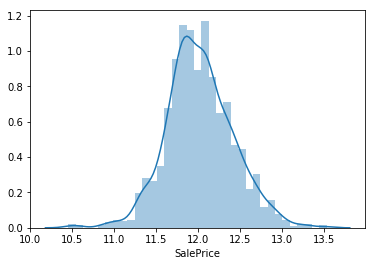

In [19]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'])

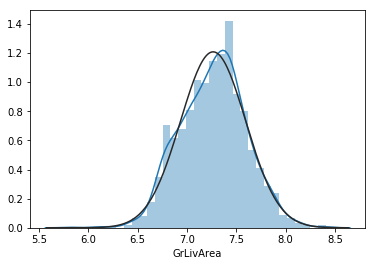

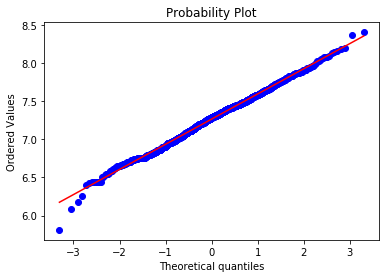

In [20]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

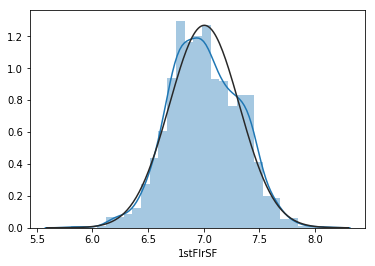

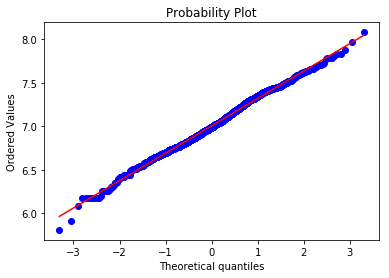

In [21]:
df_train['1stFlrSF'] = np.log(df_train['1stFlrSF'])
df_test['1stFlrSF'] = np.log(df_test['1stFlrSF'])
sns.distplot(df_train['1stFlrSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['1stFlrSF'], plot=plt)

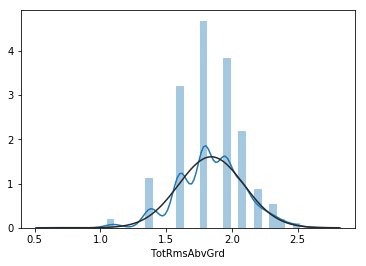

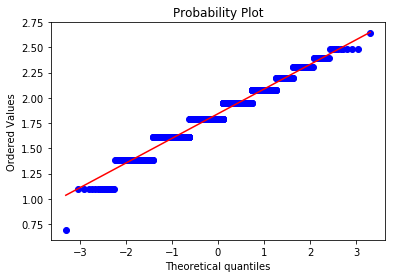

In [22]:
df_train['TotRmsAbvGrd'] = np.log(df_train['TotRmsAbvGrd'])
df_test['TotRmsAbvGrd'] = np.log(df_test['TotRmsAbvGrd'])
sns.distplot(df_train['TotRmsAbvGrd'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotRmsAbvGrd'], plot=plt)

In [23]:
df_train = df_train[cols]
df_test = df_test[cols[1:]]
df_train = df_train.as_matrix()
df_test = df_test.as_matrix()
print(df_train.shape, df_test.shape)
train_x = df_train[:, 1:].astype(np.float32)
train_t = df_train[:, :1].astype(np.float32)

test_x = df_test.astype(np.float32)
thresh_hold = int(train_x.shape[0]*0.8)
train = datasets.TupleDataset(train_x[:thresh_hold], train_t[:thresh_hold])
valid = datasets.TupleDataset(train_x[thresh_hold:], train_t[thresh_hold:])


(1458, 11) (1459, 10)


In [24]:
class LinearBlock(chainer.Chain):

    def __init__(self, inp=None, mid=256, drop=False, bn = False):
        w = chainer.initializers.HeNormal()
        super(LinearBlock, self).__init__()
        with self.init_scope():
            self.fc = L.Linear(inp, mid, initialW=w)
            self.bnorm = L.BatchNormalization(mid)
        self.drop = drop
        self.bn = bn

    def __call__(self, x):
        h = self.fc(x)
        if self.bn:
            h = self.bnorm(h)
        h = F.relu(h)
        if self.drop:
            h = F.dropout(h)
        return h
    
class MyNetwork(chainer.Chain):
    def __init__(self):
        super(MyNetwork, self).__init__()
        w = chainer.initializers.HeNormal()
        
        with self.init_scope():
            self.l1 = LinearBlock(mid = 128, bn = True)
            self.l2 = LinearBlock(mid = 64, drop = True)
            
            self.l3 = LinearBlock(mid = 64, bn = True)
            self.l4 = LinearBlock(mid = 32, drop = True)
            
            self.l5 = LinearBlock(mid = 32, bn = True)
            self.l6 = LinearBlock(mid = 16, drop = True)
            
            self.l7 = LinearBlock(mid = 16, bn = True)
            self.l8 = LinearBlock(mid = 8, drop = True)
            
            self.last1 = L.Linear(None, 1, initialW=w)
            
            self.last2 = L.Linear(None, 1, initialW=w)
            
            self.last3 = L.Linear(None, 1, initialW=w)
            
            self.last4 = L.Linear(None, 1, initialW=w)
    def __call__(self, x):
        h1 = self.last1(self.l2(self.l1(x)))
        h2 = self.last2(self.l4(self.l3(x)))
        h3 = self.last3(self.l6(self.l5(x)))
        h4 = self.last4(self.l8(self.l7(x)))
        h = F.concat((h1, h2, h3, h4))
        #h = h1
        h = F.mean(h, axis=-1, keepdims=True)

        return h

In [25]:
batch_size = 128
train_iter = iterators.SerialIterator(train, batch_size)
valid_iter  = iterators.SerialIterator(valid, batch_size, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(test_x, batch_size, False, False)

In [26]:
net = MyNetwork()
if device >= 0:
    net.to_gpu(device)

In [27]:
net = L.Classifier(net, lossfun=F.mean_squared_error)
net.compute_accuracy = False
optimizer = optimizers.Adam(alpha=0.0002, beta1=0.9, beta2=0.999).setup(net)
optimizer.add_hook(chainer.optimizer.WeightDecay(0.0001))
updater = training.StandardUpdater(train_iter, optimizer, device=device)
max_epoch = 10000
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='results')
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'), trigger=(100,'epoch'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=device), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'val/main/loss', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [ ]:
trainer.run()

epoch       main/loss   val/main/loss  elapsed_time
1           142.323     98.9269        1.27374       
2           138.123     119.465        1.43589       
3           133.728     126.562        1.59715       
4           130.712     126.426        1.76301       
5           127.045     123.655        1.93219       
6           123.712     120.523        2.10698       
7           119.516     116.565        2.27268       
8           115.892     112.85         2.43991       
9           111.596     108.942        2.61146       
10          107.444     104.581        2.79698       
11          103.946     101.083        2.96068       
12          99.7537     96.9619        3.12575       
13          95.916      92.772         3.29099       
14          92.6221     88.6334        3.51947       
15          87.3923     84.3676        3.68725       
16          83.3534     80.3943        3.85731       
17          80.2607     76.5495        4.02743       
18          76.9266     72.668

144         11.5113     9.86439        27.0324       
145         11.7148     10.0748        27.2098       
146         12.2349     9.42695        27.3881       
147         11.2887     8.50129        27.5746       
148         10.6846     8.24001        27.7508       
149         10.6631     8.48584        27.9317       
150         11.1522     8.88403        28.1088       
151         10.5839     9.1916         28.2891       
152         10.5015     8.15555        28.4667       
153         10.9137     7.84074        28.645        
154         9.83391     7.88395        28.8245       
155         10.386      8.74395        29.0032       
156         10.1382     8.68596        29.1917       
157         10.2268     7.69832        29.3728       
158         9.76523     7.24554        29.5529       
159         10.363      7.7314         29.7263       
160         10.0402     7.79495        29.9141       
161         9.96007     7.52774        30.0916       
162         9.47648     7.21

288         4.0842      1.92862        53.7361       
289         4.60466     1.80486        53.9144       
290         4.24896     2.62216        54.0911       
291         4.51854     2.26343        54.2664       
292         4.12288     1.8282         54.4469       
293         4.37455     2.05919        54.6322       
294         4.23432     3.17624        54.8108       
295         4.19498     2.46503        54.9905       
296         4.23131     2.79991        55.1678       
297         4.31194     1.65392        55.3462       
298         4.17002     2.50797        55.5234       
299         4.24033     2.97407        55.6994       
300         4.46404     1.66565        55.8764       
301         4.3605      1.4432         56.0956       
302         4.22782     1.41995        56.2795       
303         3.95174     1.45692        56.4562       
304         3.88962     1.42331        56.6302       
305         4.14682     1.39763        56.806        
306         3.98416     1.38

432         3.20638     0.605824       81.2368       
433         2.96252     0.778996       81.414        
434         3.19711     1.00052        81.5927       
435         2.91757     1.13254        81.7705       
436         2.86997     0.955519       81.9501       
437         2.85918     0.561495       82.1261       
438         3.11407     0.601698       82.3049       
439         2.98903     0.714202       82.4934       
440         2.95766     0.71552        82.6678       
441         2.89504     1.08265        82.8444       
442         2.78615     1.02504        83.0276       
443         3.08313     1.08669        83.2097       
444         2.88894     0.676208       83.388        
445         2.90859     0.545716       83.5652       
446         2.8792      0.63523        83.7426       
447         2.84945     0.89332        83.9255       
448         2.92977     0.491815       84.1036       
449         3.01535     0.539211       84.2941       
450         2.87751     0.50

576         2.68874     0.265807       108.147       
577         2.27054     0.254066       108.341       
578         2.51489     0.596999       108.524       
579         2.52438     0.57471        108.71        
580         2.58709     0.324214       108.893       
581         2.63692     0.354481       109.075       
582         2.41056     0.2431         109.259       
583         2.62542     0.519964       109.475       
584         2.39549     0.463642       109.658       
585         2.64973     0.275562       109.84        
586         2.42283     0.244489       110.034       
587         2.44277     0.250473       110.223       
588         2.56976     0.230281       110.409       
589         2.3891      0.230313       110.596       
590         2.50734     0.274459       110.781       
591         2.54352     0.281737       110.97        
592         2.47599     0.260906       111.158       
593         2.32299     0.402838       111.339       
594         2.52642     0.47

720         2.42604     0.409248       136.211       
721         2.21169     0.130934       136.393       
722         2.38291     0.167677       136.58        
723         2.26978     0.154908       136.778       
724         2.3896      0.17241        136.965       
725         2.33015     0.206774       137.154       
726         2.37181     0.16907        137.342       
727         2.2791      0.215065       137.529       
728         2.28085     0.209883       137.716       
729         2.32486     0.148071       137.902       
730         2.1379      0.144392       138.088       
731         2.24646     0.173492       138.274       
732         2.29815     0.837273       138.476       
733         2.54616     0.448071       138.662       
734         2.23598     0.27213        138.848       
735         2.34238     0.14001        139.033       
736         2.19712     0.134815       139.222       
737         2.14711     0.192657       139.409       
738         2.31273     0.25

864         2.15784     0.0902118      164.776       
865         2.12657     0.103062       164.983       
866         2.11101     0.406862       165.166       
867         2.22291     0.768464       165.357       
868         2.31314     0.198385       165.544       
869         2.20883     0.119231       165.739       
870         2.2587      0.0961052      165.927       
871         2.11647     0.102002       166.113       
872         1.99676     0.262105       166.3         
873         1.98608     0.0996093      166.485       
874         2.08134     0.236911       166.672       
875         2.10837     0.213081       166.857       
876         2.11717     0.331921       167.053       
877         2.11168     0.168257       167.242       
878         2.24809     0.197148       167.439       
879         2.14251     0.488095       167.624       
880         2.19522     0.283172       167.809       
881         2.30285     0.185973       167.996       
882         2.10189     0.09

1008        2.06771     0.126826       193.333       
1009        2.11377     0.0735581      193.521       
1010        1.93223     0.0733928      193.709       
1011        1.9373      0.0843727      193.896       
1012        1.99731     0.170083       194.084       
1013        2.07522     0.114412       194.272       
1014        2.18307     0.112789       194.462       
1015        1.92942     0.533216       194.664       
1016        2.10965     0.229422       194.856       
1017        2.12882     0.140002       195.049       
1018        2.10706     0.474866       195.247       
1019        2.00676     0.362295       195.437       
1020        2.05409     0.0718794      195.625       
1021        1.99258     0.215785       195.814       
1022        2.05297     0.230774       196.003       
1023        2.01625     0.0772726      196.191       
1024        2.10662     0.220052       196.38        
1025        1.91286     0.408535       196.579       
1026        2.08148     0.07

1152        1.88448     0.072505       222.716       
1153        1.89393     0.0624867      222.918       
1154        1.96352     0.0618314      223.109       
1155        1.93343     0.0605013      223.3         
1156        1.99646     0.0630474      223.493       
1157        1.97773     0.0899224      223.686       
1158        1.9417      0.121293       223.878       
1159        1.85084     0.140418       224.074       
1160        1.87045     0.282643       224.268       
1161        1.88216     0.514423       224.469       
1162        1.85089     0.236449       224.671       
1163        1.78657     0.0963414      224.865       
1164        2.06171     0.0558594      225.059       
1165        1.88949     0.0604442      225.264       
1166        1.84564     0.0648097      225.46        
1167        1.95339     0.122562       225.652       
1168        1.83739     0.0694757      225.845       
1169        2.23127     0.0613975      226.036       
1170        2.0295      0.06

1296        1.6389      0.0967704      251.055       
1297        1.85907     0.138599       251.251       
1298        1.81473     0.283903       251.445       
1299        1.9054      0.0908882      251.649       
1300        2.0456      0.318048       251.843       
1301        1.86709     0.0661907      252.101       
1302        1.74884     0.0554649      252.292       
1303        1.91686     0.0529891      252.487       
1304        1.89569     0.140826       252.684       
1305        1.74887     0.1579         252.88        
1306        1.70442     0.268496       253.077       
1307        1.80399     0.0596622      253.27        
1308        1.77211     0.0759607      253.476       
1309        1.90457     0.152664       253.671       
1310        1.69396     0.184564       253.867       
1311        1.84371     0.167858       254.06        
1312        1.90669     0.0522445      254.261       
1313        1.72954     0.0520329      254.456       
1314        1.79852     0.13

1440        1.89303     0.0555981      282.114       
1441        1.71597     0.121174       282.312       
1442        1.67783     0.193256       282.51        
1443        1.75386     0.062617       282.711       
1444        1.72155     0.0878879      282.914       
1445        1.742       0.0548569      283.121       
1446        1.78945     0.0462705      283.321       
1447        1.69873     0.231255       283.519       
1448        1.74079     0.0680046      283.719       
1449        1.76837     0.0486526      283.917       
1450        1.7918      0.0525218      284.118       
1451        1.78        0.0510998      284.316       
1452        1.76224     0.087237       284.517       
1453        1.8151      0.082605       284.718       
1454        1.8162      0.265693       284.929       
1455        1.80504     0.154083       285.131       
1456        1.8581      0.2417         285.33        
1457        1.81035     0.195559       285.532       
1458        1.79562     0.19

1584        1.6974      0.260062       311.767       
1585        1.79622     0.155612       311.98        
1586        1.63754     0.0758141      312.185       
1587        1.66983     0.0487661      312.401       
1588        1.68265     0.0541226      312.614       
1589        1.74669     0.212687       312.825       
1590        1.90252     0.0504622      313.031       
1591        1.72881     0.0440891      313.245       
1592        1.59041     0.0743243      313.45        
1593        1.69703     0.0940864      313.654       
1594        1.72783     0.061415       313.863       
1595        1.6397      0.226903       314.068       
1596        1.72725     0.114511       314.274       
1597        1.67596     0.0900371      314.479       
1598        1.7541      0.0537107      314.686       
1599        1.70345     0.0585916      314.891       
1600        1.74634     0.471144       315.099       
1601        1.71815     0.0937761      315.389       
1602        1.7107      0.05

1728        1.61089     0.0703781      344.311       
1729        1.64222     0.104371       344.525       
1730        1.6342      0.439264       344.73        
1731        1.60346     0.24111        344.938       
1732        1.63121     0.0436385      345.146       
1733        1.5828      0.0375729      345.351       
1734        1.55522     0.0876785      345.557       
1735        1.80212     0.141725       345.765       
1736        1.60747     0.0436987      345.97        
1737        1.6561      0.0462225      346.169       
1738        1.57255     0.179762       346.377       
1739        1.6136      0.13223        346.581       
1740        1.67158     0.0552934      346.786       
1741        1.66395     0.0433876      346.989       
1742        1.47362     0.160491       347.195       
1743        1.6134      0.0648266      347.399       
1744        1.80503     0.128114       347.604       
1745        1.66429     0.252848       347.813       
1746        1.53219     0.06

1872        1.57153     0.0388079      374.256       
1873        1.54794     0.0524996      374.468       
1874        1.64229     0.150669       374.675       
1875        1.56106     0.244526       374.889       
1876        1.47582     0.435172       375.096       
1877        1.46031     0.0487829      375.294       
1878        1.46563     0.176629       375.499       
1879        1.56496     0.068824       375.706       
1880        1.64098     0.0386831      375.916       
1881        1.67797     0.108083       376.118       
1882        1.62363     0.0606394      376.321       
1883        1.5124      0.0393044      376.523       
1884        1.4795      0.0720769      376.739       
1885        1.60251     0.0566437      376.944       
1886        1.52589     0.0465342      377.151       
1887        1.59997     0.0426031      377.359       
1888        1.57105     0.0358151      377.568       
1889        1.56927     0.154728       377.774       
1890        1.59416     0.12

2016        1.46747     0.133882       407.89        
2017        1.51217     0.15096        408.104       
2018        1.59087     0.522482       408.312       
2019        1.54341     0.0862901      408.525       
2020        1.44707     0.169201       408.735       
2021        1.60739     0.0565673      408.955       
2022        1.48124     0.233538       409.166       
2023        1.39781     0.25908        409.378       
2024        1.54297     0.225983       409.59        
2025        1.5063      0.0518846      409.801       
2026        1.56335     0.0437259      410.011       
2027        1.58856     0.0587868      410.226       
2028        1.47147     0.0709766      410.437       
2029        1.50756     0.10123        410.648       
2030        1.50469     0.114118       410.87        
2031        1.46207     0.0547352      411.078       
2032        1.40833     0.0389587      411.288       
2033        1.56698     0.102619       411.491       
2034        1.53274     0.03

2160        1.44464     0.0631789      438.108       
2161        1.48053     0.147267       438.317       
2162        1.44468     0.102535       438.522       
2163        1.49696     0.038725       438.735       
2164        1.49386     0.187587       438.942       
2165        1.3066      0.137343       439.153       
2166        1.36905     0.0858721      439.36        
2167        1.34297     0.12589        439.577       
2168        1.34797     0.175135       439.791       
2169        1.45712     0.0804686      440.001       
2170        1.40806     0.0891609      440.211       
2171        1.38876     0.0383557      440.421       
2172        1.37093     0.0347525      440.631       
2173        1.42521     0.0907931      440.841       
2174        1.37503     0.0862074      441.046       
2175        1.4184      0.0883823      441.25        
2176        1.535       0.0408829      441.457       
2177        1.29282     0.0466143      441.673       
2178        1.30045     0.06

2304        1.30033     0.0894528      468.416       
2305        1.25692     0.0422083      468.635       
2306        1.1868      0.257579       468.843       
2307        1.33704     0.182638       469.042       
2308        1.32658     0.033926       469.249       
2309        1.38478     0.0391515      469.46        
2310        1.33145     0.112248       469.667       
2311        1.31093     0.145414       469.874       
2312        1.39436     0.149944       470.084       
2313        1.28572     0.0623078      470.291       
2314        1.22753     0.037448       470.512       
2315        1.29509     0.0392728      470.73        
2316        1.32593     0.0342888      470.946       
2317        1.35437     0.0555347      471.151       
2318        1.31611     0.11278        471.358       
2319        1.26005     0.0859615      471.567       
2320        1.25894     0.0467273      471.777       
2321        1.30115     0.142595       471.99        
2322        1.36341     0.16

2448        1.25553     0.0491406      499.227       
2449        1.28037     0.0389442      499.441       
2450        1.26311     0.0503976      499.66        
2451        1.22124     0.0488942      499.892       
2452        1.22724     0.0404475      500.105       
2453        1.19311     0.0739794      504.278       
2454        1.16536     0.19356        504.488       
2455        1.27226     0.0619946      504.699       
2456        1.30521     0.0346326      504.911       
2457        1.2724      0.0666778      505.12        
2458        1.19153     0.0308094      505.333       
2459        1.25335     0.0897329      505.544       
2460        1.22499     0.0391148      505.779       
2461        1.13125     0.0307426      505.996       
2462        1.1908      0.300877       506.223       
2463        1.27467     0.0833719      506.444       
2464        1.26478     0.040553       506.671       
2465        1.19485     0.049706       506.903       
2466        1.30286     0.13

2592        1.16313     0.0321128      534.535       
2593        1.20993     0.190757       534.748       
2594        1.17632     0.204054       534.962       
2595        1.21047     0.0388737      535.177       
2596        1.18029     0.0715477      535.393       
2597        1.17277     0.131158       535.617       
2598        1.10318     0.0353178      535.864       
2599        1.10512     0.0987665      536.095       
2600        1.2121      0.0568786      536.311       
2601        1.12357     0.0348544      536.625       
2602        1.18023     0.0379947      536.838       
2603        1.22145     0.0372085      537.045       
2604        1.08274     0.0708301      537.258       
2605        1.1126      0.107723       537.471       
2606        1.16118     0.314887       537.697       
2607        1.11446     0.564367       537.911       
2608        1.13318     0.0775625      538.125       
2609        1.15336     0.0909227      538.337       
2610        1.10636     0.03

2736        1.04779     0.0891138      566.412       
2737        1.02441     0.0298144      566.627       
2738        1.09393     0.22519        566.842       
2739        1.05917     0.048094       567.058       
2740        1.05613     0.0493365      567.274       
2741        1.08034     0.0511087      567.487       
2742        1.14919     0.126358       567.703       
2743        1.04625     0.0520272      567.927       
2744        0.989886    0.055671       568.141       
2745        1.09231     0.0369145      568.36        
2746        1.04887     0.0771348      568.574       
2747        1.07063     0.0863351      568.786       
2748        1.08092     0.0559656      569.006       
2749        1.07717     0.295949       569.222       
2750        1.06784     0.135641       569.436       
2751        1.08228     0.0625803      569.654       
2752        1.04996     0.0599945      569.872       
2753        1.08447     0.0878054      570.097       
2754        1.13089     0.25

2880        0.963586    0.0345869      598.154       
2881        0.967972    0.0301453      598.387       
2882        0.973677    0.031974       598.61        
2883        0.943878    0.052403       598.835       
2884        0.922977    0.06969        599.058       
2885        0.926862    0.106319       599.274       
2886        0.963469    0.0839553      599.492       
2887        0.976668    0.0313032      599.712       
2888        0.974604    0.0396522      599.935       
2889        0.985759    0.0367159      600.157       
2890        1.02595     0.0546551      600.388       
2891        0.898387    0.13103        600.61        
2892        0.904281    0.0984073      600.839       
2893        0.904265    0.036134       601.061       
2894        0.90282     0.0420987      601.284       
2895        0.97553     0.049287       601.506       
2896        0.891912    0.121819       601.725       
2897        0.984415    0.141521       601.946       
2898        0.971713    0.12

3024        0.943723    0.0306516      635.573       
3025        0.894295    0.0454275      635.809       
3026        0.913584    0.0742872      636.045       
3027        0.938253    0.0348771      636.285       
3028        0.877482    0.257281       636.519       
3029        0.96468     0.0370201      636.751       
3030        0.905925    0.0421985      636.992       
3031        0.90529     0.057969       637.226       
3032        0.883293    0.0927514      637.453       
3033        0.932079    0.397601       637.675       
3034        0.929336    0.082796       637.898       
3035        0.91643     0.0330911      638.122       
3036        0.896885    0.0884128      638.352       
3037        0.872633    0.0664138      638.579       
3038        0.831338    0.081234       638.802       
3039        0.920821    0.0435232      639.026       
3040        0.83075     0.0332594      639.248       
3041        0.98629     0.0412654      639.465       
3042        0.896567    0.09

3168        0.801466    0.0598747      668.437       
3169        0.839608    0.161886       668.661       
3170        0.795378    0.215398       668.885       
3171        0.927775    0.0907192      669.139       
3172        0.903108    0.0891915      669.388       
3173        0.857618    0.0373923      669.623       
3174        0.868035    0.0415135      669.847       
3175        0.837244    0.0365694      670.071       
3176        0.811789    0.0967397      670.3         
3177        0.891986    0.0305677      670.525       
3178        0.867631    0.138133       670.795       
3179        0.842837    0.169107       671.034       
3180        0.901359    0.0316603      671.254       
3181        0.865388    0.031112       671.479       
3182        0.839533    0.130833       671.714       
3183        0.833359    0.0357706      671.939       
3184        0.894455    0.257056       672.164       
3185        0.847463    0.274233       672.389       
3186        0.866545    0.08

3312        0.791907    0.109353       701.99        
3313        0.728976    0.12507        702.222       
3314        0.772407    0.070758       702.462       
3315        0.699786    0.0448108      702.689       
3316        0.820697    0.0855855      702.918       
3317        0.75578     0.353552       703.149       
3318        0.756963    0.0934025      703.379       
3319        0.837036    0.0736402      703.618       
3320        0.789742    0.0376869      703.856       
3321        0.837032    0.0452123      704.089       
3322        0.755149    0.0906663      704.316       
3323        0.700307    0.0415002      704.542       
3324        0.764329    0.0540126      704.767       
3325        0.718527    0.0331828      704.996       
3326        0.777318    0.0279378      705.221       
3327        0.787469    0.0366861      705.452       
3328        0.75405     0.042296       705.684       
3329        0.811538    0.0950291      705.926       
3330        0.754524    0.04

3456        0.717374    0.0500515      735.755       
3457        0.709716    0.0358259      736.002       
3458        0.720484    0.0327935      736.235       
3459        0.699793    0.0948281      736.478       
3460        0.743262    0.0325471      736.715       
3461        0.735756    0.0433924      736.949       
3462        0.696426    0.0339372      737.184       
3463        0.68812     0.0433318      737.415       
3464        0.709168    0.0552863      737.647       
3465        0.694642    0.0281821      737.878       
3466        0.667793    0.0511195      738.119       
3467        0.737747    0.0345841      738.351       
3468        0.712572    0.0356072      738.581       
3469        0.686418    0.0513971      738.812       
3470        0.711397    0.130062       739.044       
3471        0.732283    0.384665       739.275       
3472        0.708808    0.109997       739.507       
3473        0.709098    0.0296602      739.739       
3474        0.695197    0.03

3600        0.681862    0.0443237      776.065       
3601        0.696769    0.0565975      776.417       
3602        0.64408     0.0315014      776.644       
3603        0.661972    0.061146       776.885       
3604        0.681373    0.0354334      777.124       
3605        0.645228    0.0723781      777.365       
3606        0.683807    0.0304864      777.598       
3607        0.688277    0.118757       777.833       
3608        0.657625    0.0298614      778.069       
3609        0.638034    0.0315365      778.304       
3610        0.699153    0.131975       778.538       
3611        0.673724    0.0964564      778.772       
3612        0.635521    0.268716       779.017       
3613        0.640628    0.0316732      779.251       
3614        0.640485    0.0325698      779.487       
3615        0.681805    0.070827       779.721       
3616        0.68342     0.0557452      779.96        
3617        0.670366    0.0307922      780.196       
3618        0.617243    0.03

3744        0.633484    0.036285       810.517       
3745        0.594906    0.0754251      810.756       
3746        0.632644    0.0503326      810.994       
3747        0.581997    0.051759       811.229       
3748        0.588254    0.0587348      811.467       
3749        0.553813    0.0568544      811.712       
3750        0.618687    0.0309533      811.945       
3751        0.607635    0.0487387      812.181       
3752        0.650744    0.0353508      812.419       
3753        0.666833    0.0823238      812.655       
3754        0.606108    0.322947       812.893       
3755        0.619837    0.082354       813.125       
3756        0.637209    0.0730611      813.364       
3757        0.634757    0.0325664      813.599       
3758        0.615108    0.0383154      813.847       
3759        0.632932    0.0333596      814.089       
3760        0.638724    0.0526253      814.326       
3761        0.618111    0.0357035      814.563       
3762        0.641251    0.11

3888        0.568066    0.0575552      845.269       
3889        0.602577    0.032222       845.509       
3890        0.583982    0.0385518      845.755       
3891        0.591371    0.0839154      845.997       
3892        0.585328    0.0412243      846.239       
3893        0.597239    0.0292869      846.482       
3894        0.561015    0.0492924      846.722       
3895        0.599818    0.0298535      846.978       
3896        0.582623    0.0359122      847.228       
3897        0.608014    0.0528318      847.471       
3898        0.597969    0.130071       847.716       
3899        0.603027    0.159033       847.959       
3900        0.59809     0.0705983      848.206       
3901        0.58406     0.177432       848.579       
3902        0.575293    0.190742       848.824       
3903        0.534593    0.0456755      849.065       
3904        0.561733    0.0343664      849.311       
3905        0.569647    0.0312605      849.565       
3906        0.619561    0.03

4032        0.522029    0.0339634      880.953       
4033        0.547409    0.0468155      881.206       
4034        0.541089    0.125286       881.45        
4035        0.538331    0.196165       881.697       
4036        0.609366    0.118659       881.942       
4037        0.545245    0.0427377      882.189       
4038        0.575965    0.0810772      882.433       
4039        0.529767    0.0320623      882.683       
4040        0.537285    0.033258       882.928       
4041        0.532706    0.0425846      883.177       
4042        0.569313    0.0420501      883.429       
4043        0.54755     0.076306       883.67        
4044        0.532427    0.0288161      883.914       
4045        0.559233    0.0346683      884.163       
4046        0.49927     0.0802695      884.398       
4047        0.546025    0.119166       884.639       
4048        0.512055    0.10016        884.888       
4049        0.556261    0.0484874      885.133       
4050        0.491779    0.02

4176        0.527919    0.150408       916.136       
4177        0.502127    0.0413336      916.371       
4178        0.468316    0.130161       916.611       
4179        0.555027    0.0451666      916.861       
4180        0.524098    0.0918649      917.107       
4181        0.506718    0.134854       917.347       
4182        0.516953    0.0402628      917.584       
4183        0.540448    0.239164       917.822       
4184        0.502421    0.0603236      918.063       
4185        0.536647    0.0729937      918.305       
4186        0.507288    0.0316334      918.544       
4187        0.545926    0.139403       918.781       
4188        0.515253    0.0307559      919.038       
4189        0.492603    0.0382536      919.276       
4190        0.527131    0.0490988      919.513       
4191        0.531087    0.0289578      919.764       
4192        0.536961    0.028586       920.005       
4193        0.487327    0.0509286      920.245       
4194        0.507834    0.05

4320        0.503692    0.0415068      951.482       
4321        0.45924     0.0642059      951.726       
4322        0.509138    0.0465748      951.966       
4323        0.544439    0.151475       952.207       
4324        0.488643    0.0857333      952.452       
4325        0.510126    0.052612       952.702       
4326        0.490769    0.0421862      952.954       
4327        0.473494    0.031234       953.196       
4328        0.524835    0.0671631      953.438       
4329        0.463029    0.0533184      953.678       
4330        0.513603    0.0427251      953.92        
4331        0.459895    0.0316061      954.159       
4332        0.499599    0.0308206      954.403       
4333        0.517008    0.0368108      954.64        
4334        0.497429    0.0447419      954.89        
4335        0.454384    0.0618008      955.13        
4336        0.49456     0.0676091      955.375       
4337        0.519137    0.0703478      955.616       
4338        0.525771    0.06

4464        0.456338    0.0463967      994.062       
4465        0.450843    0.0311784      994.308       
4466        0.487812    0.0306987      994.551       
4467        0.472589    0.0631116      994.8         
4468        0.43421     0.0450855      995.044       
4469        0.487332    0.0358708      995.289       
4470        0.480936    0.0286048      995.532       
4471        0.47076     0.0781572      995.786       
4472        0.478163    0.0607569      996.035       
4473        0.466509    0.159996       996.275       
4474        0.473364    0.110113       996.521       
4475        0.467054    0.037056       996.766       
4476        0.474561    0.104204       997.009       
4477        0.481915    0.085472       997.246       
4478        0.471516    0.0301309      997.484       
4479        0.466901    0.0508255      997.723       
4480        0.448931    0.0283746      997.964       
4481        0.455272    0.0464537      998.216       
4482        0.423079    0.07

4608        0.426059    0.0286026      1030          
4609        0.419745    0.025487       1030.25       
4610        0.437511    0.0266015      1030.5        
4611        0.448008    0.108409       1030.74       
4612        0.438032    0.12007        1030.99       
4613        0.439953    0.0303376      1031.23       
4614        0.437328    0.0413219      1031.49       
4615        0.423026    0.0281214      1031.73       
4616        0.466383    0.0451844      1031.98       
4617        0.433622    0.0300852      1032.22       
4618        0.446189    0.0311068      1032.48       
4619        0.483595    0.0579887      1032.72       
4620        0.425397    0.0307059      1032.97       
4621        0.430301    0.0299042      1033.22       
4622        0.436032    0.073599       1033.47       
4623        0.435703    0.0434328      1033.72       
4624        0.460103    0.039733       1033.97       
4625        0.462404    0.0466169      1034.22       
4626        0.401444    0.02

4752        0.422459    0.0355742      1066.25       
4753        0.428388    0.0335984      1066.5        
4754        0.439247    0.124763       1066.76       
4755        0.43395     0.0662035      1067.02       
4756        0.433004    0.0419688      1067.27       
4757        0.402999    0.0389646      1067.51       
4758        0.417347    0.038122       1067.77       
4759        0.395793    0.03036        1068.02       
4760        0.401188    0.0322645      1068.27       
4761        0.420864    0.164374       1068.52       
4762        0.42739     0.0541418      1068.77       
4763        0.411088    0.10599        1069.02       
4764        0.425289    0.0364979      1069.29       
4765        0.417076    0.139778       1069.54       
4766        0.402025    0.0402084      1069.79       
4767        0.403186    0.0710885      1070.05       
4768        0.441448    0.0913834      1070.3        
4769        0.429489    0.0293423      1070.55       
4770        0.433567    0.13

4896        0.41479     0.0954039      1102.94       
4897        0.384689    0.0557974      1103.19       
4898        0.389927    0.0638016      1103.44       
4899        0.414155    0.0516205      1103.7        
4900        0.407116    0.0334365      1103.95       
4901        0.391081    0.0332705      1104.38       
4902        0.380838    0.0674558      1104.63       
4903        0.412848    0.0383204      1104.89       
4904        0.393149    0.033951       1105.14       
4905        0.416389    0.0572648      1105.4        
4906        0.392448    0.0352624      1105.65       
4907        0.413483    0.0264863      1105.9        
4908        0.40325     0.0432468      1106.16       
4909        0.38132     0.0305958      1106.41       
4910        0.384413    0.0344028      1106.68       
4911        0.389516    0.0373234      1106.93       
4912        0.40584     0.034064       1107.18       
4913        0.427789    0.0985171      1107.43       
4914        0.36005     0.11

5040        0.371305    0.0400096      1140.08       
5041        0.379615    0.029141       1140.33       
5042        0.388727    0.0532728      1140.58       
5043        0.356064    0.107          1140.84       
5044        0.375273    0.0289624      1141.1        
5045        0.384181    0.0269631      1141.35       
5046        0.397172    0.0323538      1141.61       
5047        0.384248    0.031979       1141.88       
5048        0.357865    0.0384429      1142.14       
5049        0.370968    0.0972371      1142.39       
5050        0.369056    0.0502058      1142.65       
5051        0.386602    0.0404568      1142.91       
5052        0.375661    0.026082       1143.16       
5053        0.362495    0.0374144      1143.42       
5054        0.379682    0.0559509      1143.67       
5055        0.368082    0.12664        1143.94       
5056        0.353214    0.0933993      1144.19       
5057        0.376417    0.064978       1144.45       
5058        0.373073    0.06

5184        0.353259    0.0763532      1177.42       
5185        0.328926    0.0394233      1177.69       
5186        0.371678    0.0284735      1177.95       
5187        0.36193     0.0321463      1178.21       
5188        0.372828    0.177179       1178.47       
5189        0.362479    0.0770611      1178.73       
5190        0.33752     0.0334985      1178.99       
5191        0.338537    0.0421786      1179.26       
5192        0.32618     0.101304       1179.52       
5193        0.360254    0.0281186      1179.78       
5194        0.339002    0.141084       1180.05       
5195        0.35612     0.0438423      1180.3        
5196        0.330788    0.0353299      1180.56       
5197        0.370464    0.0761425      1180.82       
5198        0.365659    0.122373       1181.08       
5199        0.336471    0.0608991      1181.34       
5200        0.381753    0.0307832      1181.6        
5201        0.327218    0.0479279      1182.03       
5202        0.350312    0.03

5328        0.324527    0.0727393      1224.22       
5329        0.35556     0.0478201      1224.48       
5330        0.314974    0.0296393      1224.74       
5331        0.334865    0.0546819      1225.02       
5332        0.359785    0.0345878      1225.28       
5333        0.319658    0.0282459      1225.54       
5334        0.310329    0.0421268      1225.81       
5335        0.323143    0.038444       1226.09       
5336        0.356331    0.062648       1226.35       
5337        0.330387    0.0311648      1226.6        
5338        0.327362    0.0446269      1226.86       
5339        0.341705    0.040881       1227.12       
5340        0.324193    0.0324639      1227.4        
5341        0.338571    0.0421008      1227.66       
5342        0.333806    0.0512172      1227.93       
5343        0.327295    0.0299385      1228.19       
5344        0.337157    0.0360203      1228.46       
5345        0.321134    0.0312788      1228.72       
5346        0.32698     0.03

5472        0.311007    0.0524084      1262.3        
5473        0.30895     0.0370916      1262.56       
5474        0.318663    0.0310532      1262.82       
5475        0.302364    0.0967599      1263.08       
5476        0.305656    0.115868       1263.35       
5477        0.295965    0.0264867      1263.62       
5478        0.321774    0.0401604      1263.89       
5479        0.311742    0.0273727      1264.15       
5480        0.311605    0.0413332      1264.42       
5481        0.31375     0.052851       1264.68       
5482        0.306396    0.07093        1264.94       
5483        0.31643     0.0554386      1265.2        
5484        0.329644    0.0487854      1265.46       
5485        0.308657    0.032169       1265.72       
5486        0.30928     0.0398748      1266          
5487        0.308685    0.0406154      1266.27       
5488        0.287572    0.0710139      1266.53       
5489        0.307181    0.121827       1266.79       
5490        0.305139    0.03

5616        0.317284    0.0389361      1301.06       
5617        0.291656    0.032171       1301.33       
5618        0.296884    0.027731       1301.59       
5619        0.295283    0.0278655      1301.86       
5620        0.285756    0.0450915      1302.12       
5621        0.305922    0.0454902      1302.38       
5622        0.307279    0.120597       1302.65       
5623        0.28574     0.0441151      1302.92       
5624        0.285361    0.058181       1303.19       
5625        0.297976    0.0479842      1303.46       
5626        0.300357    0.0434577      1303.72       
5627        0.306125    0.255106       1303.99       
5628        0.286222    0.0861722      1304.25       
5629        0.274555    0.0319523      1304.52       
5630        0.284965    0.0288042      1304.79       
5631        0.302128    0.0568951      1305.05       
5632        0.276223    0.0269598      1305.31       
5633        0.303522    0.061857       1305.58       
5634        0.309605    0.03

5760        0.277385    0.0780688      1340.12       
5761        0.271288    0.0333917      1340.4        
5762        0.274755    0.0288399      1340.66       
5763        0.286892    0.0334939      1340.93       
5764        0.276651    0.0328462      1341.2        
5765        0.276042    0.0415146      1341.46       
5766        0.282664    0.0265565      1341.73       
5767        0.262192    0.0368814      1341.99       
5768        0.279447    0.0392729      1342.26       
5769        0.282536    0.0332643      1342.53       
5770        0.27079     0.109092       1342.81       
5771        0.276974    0.0672519      1343.08       
5772        0.264494    0.0331896      1343.35       
5773        0.268641    0.0339105      1343.61       
5774        0.254973    0.0382761      1343.88       
5775        0.256755    0.0319941      1344.15       
5776        0.271719    0.0386063      1344.42       
5777        0.259513    0.0303116      1344.69       
5778        0.265403    0.02

5904        0.260903    0.0325633      1379.7        
5905        0.256139    0.038081       1379.98       
5906        0.277689    0.0638307      1380.25       
5907        0.262676    0.0408912      1380.53       
5908        0.268954    0.0380972      1380.81       
5909        0.254235    0.0551161      1381.1        
5910        0.256446    0.109976       1381.38       
5911        0.266328    0.0466654      1381.65       
5912        0.262366    0.029322       1381.93       
5913        0.241507    0.0272732      1382.22       
5914        0.249529    0.0331438      1382.5        
5915        0.263798    0.0339246      1382.77       
5916        0.278386    0.0396613      1383.06       
5917        0.273641    0.0286859      1383.32       
5918        0.252106    0.0373716      1383.59       
5919        0.275105    0.0616172      1383.86       
5920        0.259699    0.0607658      1384.12       
5921        0.261504    0.273438       1384.39       
5922        0.273768    0.05

6048        0.261048    0.0325367      1419.66       
6049        0.261277    0.254376       1419.94       
6050        0.240313    0.0403232      1420.21       
6051        0.254345    0.0275202      1420.49       
6052        0.256627    0.0416021      1420.79       
6053        0.242085    0.0666296      1421.08       
6054        0.260076    0.0277011      1421.37       
6055        0.234126    0.0294018      1421.64       
6056        0.249937    0.0469439      1421.92       
6057        0.243322    0.0343475      1422.19       
6058        0.247187    0.0715547      1422.46       
6059        0.238671    0.0518701      1422.74       
6060        0.25432     0.0282126      1423.01       
6061        0.236004    0.0724492      1423.29       
6062        0.244618    0.0292299      1423.57       
6063        0.267707    0.0286117      1423.85       
6064        0.256488    0.035562       1424.12       
6065        0.245068    0.0323396      1424.4        
6066        0.240562    0.02

6192        0.230416    0.0450658      1459.73       
6193        0.220765    0.100175       1460.01       
6194        0.232141    0.0547596      1460.29       
6195        0.235559    0.0298513      1460.56       
6196        0.207978    0.0502858      1460.84       
6197        0.22946     0.0285735      1461.12       
6198        0.239669    0.102672       1461.39       
6199        0.232264    0.0327378      1461.67       
6200        0.230307    0.0550584      1461.94       
6201        0.239328    0.0328535      1462.42       
6202        0.22103     0.0411213      1462.69       
6203        0.219694    0.030135       1462.97       
6204        0.240196    0.0702022      1463.24       
6205        0.253173    0.0357811      1463.52       
6206        0.222427    0.063215       1463.79       
6207        0.237341    0.0542024      1464.06       
6208        0.220749    0.0268387      1464.33       
6209        0.227757    0.038331       1464.61       
6210        0.231429    0.02

6336        0.221895    0.0906618      1500.03       
6337        0.226525    0.0288251      1500.32       
6338        0.213593    0.0317822      1500.6        
6339        0.225432    0.108582       1500.88       
6340        0.21882     0.0287087      1501.15       
6341        0.219874    0.034863       1501.43       
6342        0.211041    0.0406601      1501.71       
6343        0.21367     0.02845        1501.99       
6344        0.222917    0.030393       1502.27       
6345        0.214647    0.0473018      1502.56       
6346        0.208968    0.0594051      1502.85       
6347        0.210351    0.0561659      1503.12       
6348        0.199546    0.032248       1503.4        
6349        0.213195    0.0399603      1503.67       
6350        0.221449    0.0294373      1503.96       
6351        0.218551    0.0346545      1504.24       
6352        0.2311      0.0322369      1504.51       
6353        0.227695    0.0683314      1504.79       
6354        0.213108    0.03

6480        0.204377    0.0542902      1551.43       
6481        0.201313    0.0449459      1551.7        
6482        0.197102    0.050303       1551.98       
6483        0.201729    0.0414301      1552.27       
6484        0.203866    0.040592       1552.55       
6485        0.218073    0.0312042      1552.83       
6486        0.202861    0.0332898      1553.11       
6487        0.208805    0.0333582      1553.39       
6488        0.206481    0.029959       1553.67       
6489        0.209361    0.0497176      1553.96       
6490        0.219461    0.0696263      1554.24       
6491        0.196016    0.0309997      1554.51       
6492        0.209535    0.0305387      1554.8        
6493        0.197708    0.0400442      1555.08       
6494        0.208967    0.0696775      1555.36       
6495        0.202992    0.0348225      1555.64       
6496        0.194935    0.0299896      1555.93       
6497        0.198611    0.0301011      1556.2        
6498        0.205216    0.06

6624        0.201431    0.193104       1592.83       
6625        0.178911    0.0500617      1593.13       
6626        0.192761    0.032137       1593.43       
6627        0.189744    0.0337816      1593.71       
6628        0.187436    0.0500666      1593.99       
6629        0.199215    0.114608       1594.28       
6630        0.185776    0.0628242      1594.57       
6631        0.194831    0.0526054      1594.85       
6632        0.192247    0.0298711      1595.14       
6633        0.185854    0.0370823      1595.42       
6634        0.196621    0.0394006      1595.71       
6635        0.189297    0.0337011      1596.04       
6636        0.200262    0.0305471      1596.32       
6637        0.176196    0.097129       1596.61       
6638        0.193535    0.0269861      1596.94       
6639        0.186662    0.0702804      1597.26       
6640        0.191688    0.0320282      1597.55       
6641        0.186493    0.0263368      1597.84       
6642        0.187457    0.06

6768        0.178796    0.0635125      1634.61       
6769        0.174512    0.0303116      1634.9        
6770        0.172634    0.0352883      1635.19       
6771        0.175711    0.0596119      1635.49       
6772        0.181181    0.0456849      1635.78       
6773        0.16567     0.0310825      1636.08       
6774        0.181831    0.0432556      1636.36       
6775        0.17999     0.037474       1636.65       
6776        0.184619    0.0310952      1636.94       
6777        0.179909    0.0297931      1637.23       
6778        0.181042    0.037183       1637.52       
6779        0.196986    0.075776       1637.8        
6780        0.17201     0.0673885      1638.09       
6781        0.168024    0.0694537      1638.37       
6782        0.187504    0.0708237      1638.66       
6783        0.181016    0.0669907      1638.94       
6784        0.178318    0.0428052      1639.23       
6785        0.173179    0.0294732      1639.52       
6786        0.178273    0.02

6912        0.163274    0.0280983      1676.96       
6913        0.17424     0.0543557      1677.25       
6914        0.175565    0.0248171      1677.54       
6915        0.154969    0.0374313      1677.83       
6916        0.17962     0.0345326      1678.12       
6917        0.175434    0.0683662      1678.41       
6918        0.170382    0.0847743      1678.71       
6919        0.171646    0.0372388      1679          
6920        0.166       0.0349985      1679.29       
6921        0.173034    0.0298631      1679.58       
6922        0.177143    0.0371085      1679.87       
6923        0.17023     0.051224       1680.17       
6924        0.174567    0.0331958      1680.45       
6925        0.168523    0.0737528      1680.74       
6926        0.158427    0.0291226      1681.03       
6927        0.16093     0.0290502      1681.32       
6928        0.167343    0.0302508      1681.61       
6929        0.177832    0.0483338      1681.91       
6930        0.160416    0.08

7056        0.16521     0.0751068      1719.34       
7057        0.165041    0.0380368      1719.64       
7058        0.166983    0.11461        1719.93       
7059        0.158821    0.0387705      1720.23       
7060        0.157409    0.026535       1720.52       
7061        0.146253    0.0470923      1720.82       
7062        0.153411    0.069005       1721.11       
7063        0.151743    0.0415712      1721.4        
7064        0.165701    0.0351831      1721.7        
7065        0.14585     0.0940221      1721.99       
7066        0.153753    0.0894902      1722.29       
7067        0.162177    0.0295819      1722.58       
7068        0.160639    0.0300499      1722.88       
7069        0.158536    0.0923886      1723.18       
7070        0.157258    0.0351941      1723.47       
7071        0.167598    0.0333871      1723.76       
7072        0.149839    0.026215       1724.06       
7073        0.161947    0.0481841      1724.35       
7074        0.154398    0.03

7200        0.138386    0.0964325      1762.26       
7201        0.147728    0.0934327      1762.77       
7202        0.148763    0.0576052      1763.07       
7203        0.155316    0.0633407      1763.37       
7204        0.138185    0.0267077      1763.66       
7205        0.142628    0.0804354      1763.96       
7206        0.136207    0.0383444      1764.26       
7207        0.144568    0.0317643      1764.55       
7208        0.149359    0.0372364      1764.85       
7209        0.146287    0.0400237      1765.15       
7210        0.141932    0.0475469      1765.46       
7211        0.144007    0.0327973      1765.75       
7212        0.151644    0.0713573      1766.09       
7213        0.150875    0.0737809      1766.43       
7214        0.149149    0.0477334      1766.75       
7215        0.143179    0.0879213      1767.04       
7216        0.155956    0.0291645      1767.33       
7217        0.140782    0.0490017      1767.62       
7218        0.151007    0.03

7344        0.139533    0.0377175      1805.59       
7345        0.139216    0.0285258      1805.89       
7346        0.139588    0.0828917      1806.18       
7347        0.128799    0.05061        1806.48       
7348        0.137317    0.0262273      1806.78       
7349        0.13767     0.0630679      1807.08       
7350        0.139885    0.0365704      1807.38       
7351        0.135951    0.0380551      1807.68       
7352        0.136133    0.0313273      1807.98       
7353        0.132261    0.0376398      1808.27       
7354        0.135934    0.0472617      1808.56       
7355        0.145441    0.0254354      1808.86       
7356        0.135244    0.0292485      1809.16       
7357        0.135483    0.0358696      1809.46       
7358        0.134204    0.0283696      1809.75       
7359        0.142286    0.0319726      1810.05       
7360        0.146235    0.0515782      1810.34       
7361        0.136136    0.0561165      1810.64       
7362        0.135425    0.08

7488        0.133747    0.0337443      1849.05       
7489        0.133377    0.133887       1849.36       
7490        0.140691    0.0601615      1849.66       
7491        0.127442    0.0347315      1849.97       
7492        0.132967    0.0548322      1850.27       
7493        0.123566    0.0486884      1850.57       
7494        0.126333    0.0377044      1850.86       
7495        0.131657    0.0443875      1851.17       
7496        0.116846    0.198468       1851.47       
7497        0.125109    0.0281093      1851.78       
7498        0.123611    0.0524861      1852.13       
7499        0.132586    0.0338571      1852.43       
7500        0.118697    0.0384586      1852.72       
7501        0.131151    0.082256       1853.25       
7502        0.133302    0.0540361      1853.54       
7503        0.125879    0.0246127      1853.84       
7504        0.134654    0.0338309      1854.14       
7505        0.130225    0.0254034      1854.43       
7506        0.125017    0.04

7632        0.113861    0.0348446      1893.23       
7633        0.119657    0.113992       1893.54       
7634        0.118582    0.100568       1893.84       
7635        0.128215    0.0288716      1894.16       
7636        0.121668    0.0545747      1894.45       
7637        0.121264    0.028536       1894.76       
7638        0.122978    0.112754       1895.06       
7639        0.119065    0.0301159      1895.35       
7640        0.117414    0.0283785      1895.65       
7641        0.123148    0.056906       1895.95       
7642        0.118774    0.048883       1896.26       
7643        0.133904    0.0288787      1896.57       
7644        0.111914    0.0335321      1896.89       
7645        0.124908    0.0483447      1897.19       
7646        0.117757    0.026108       1897.49       
7647        0.127936    0.0326441      1897.79       
7648        0.11306     0.0363458      1898.1        
7649        0.113927    0.0279166      1898.4        
7650        0.121105    0.03

7776        0.10168     0.0994619      1950.79       
7777        0.116086    0.087464       1951.09       
7778        0.11421     0.0329629      1951.39       
7779        0.111975    0.0349662      1951.7        
7780        0.106998    0.0329935      1952.01       
7781        0.110275    0.0330448      1952.32       
7782        0.107291    0.0320975      1952.61       
7783        0.112718    0.0288008      1952.92       
7784        0.120211    0.0578414      1953.22       
7785        0.107806    0.0341134      1953.52       
7786        0.116561    0.0284884      1953.82       
7787        0.115298    0.0262166      1954.13       
7788        0.115469    0.0940165      1954.43       
7789        0.108902    0.0850001      1954.73       
7790        0.103846    0.0321709      1955.05       
7791        0.110618    0.0609317      1955.35       
7792        0.109731    0.038768       1955.65       
7793        0.111822    0.0320177      1955.96       
7794        0.115012    0.05

7920        0.108962    0.036205       1995.83       
7921        0.10807     0.0586441      1996.14       
7922        0.10682     0.0290428      1996.45       
7923        0.104147    0.0474316      1996.76       
7924        0.10795     0.0315848      1997.08       
7925        0.114413    0.0306291      1997.39       
7926        0.108738    0.0290977      1997.7        
7927        0.102982    0.0371668      1998.02       
7928        0.107723    0.0328505      1998.32       
7929        0.104388    0.0254145      1998.62       
7930        0.103022    0.0458376      1998.94       
7931        0.105012    0.0279608      1999.25       
7932        0.100045    0.137255       1999.56       
7933        0.109135    0.0322319      1999.87       
7934        0.107082    0.0376868      2000.18       
7935        0.0995487   0.0382007      2000.49       
7936        0.0969525   0.0256957      2000.81       
7937        0.104032    0.0312748      2001.16       
7938        0.102466    0.14

8064        0.101591    0.144361       2040.86       
8065        0.101379    0.112824       2041.19       
8066        0.102841    0.0279853      2041.51       
8067        0.104463    0.0998511      2041.83       
8068        0.100341    0.0295556      2042.15       
8069        0.101834    0.0340431      2042.48       
8070        0.102359    0.0300419      2042.8        
8071        0.100518    0.0291472      2043.13       
8072        0.0970207   0.0312384      2043.44       
8073        0.0937234   0.104604       2043.75       
8074        0.0970508   0.123735       2044.07       
8075        0.0979055   0.0735616      2044.38       
8076        0.0961239   0.0333733      2044.68       
8077        0.0934214   0.0658328      2044.99       
8078        0.104535    0.03236        2045.3        
8079        0.0959968   0.0413658      2045.61       
8080        0.0973224   0.179826       2045.93       
8081        0.102317    0.0286987      2046.24       
8082        0.0955299   0.02

8208        0.0904699   0.0605732      2086.33       
8209        0.0976935   0.0370687      2086.64       
8210        0.0875212   0.0895402      2086.96       
8211        0.089916    0.0365187      2087.28       
8212        0.100877    0.0253935      2087.58       
8213        0.0887099   0.0288625      2087.88       
8214        0.0878508   0.0434831      2088.19       
8215        0.0932608   0.0365926      2088.49       
8216        0.0859604   0.0276892      2088.79       
8217        0.0886539   0.0642115      2089.11       
8218        0.0980726   0.095149       2089.42       
8219        0.096918    0.0334261      2089.73       
8220        0.0926684   0.096178       2090.04       
8221        0.0900326   0.0402281      2090.35       
8222        0.0936265   0.0603374      2090.65       
8223        0.0930033   0.0559894      2090.96       
8224        0.0923431   0.0602923      2091.26       
8225        0.0897477   0.0254065      2091.57       
8226        0.0888857   0.05

8352        0.0797347   0.0830078      2131.03       
8353        0.0829459   0.0255718      2131.33       
8354        0.0864196   0.0708336      2131.63       
8355        0.0842703   0.0403013      2131.94       
8356        0.0843023   0.0291719      2132.24       
8357        0.0862566   0.0315141      2132.55       
8358        0.0846905   0.0273559      2132.86       
8359        0.0815439   0.0433192      2133.16       
8360        0.0898359   0.0378835      2133.47       
8361        0.086006    0.0601747      2133.78       
8362        0.0801612   0.0350883      2134.09       
8363        0.0892461   0.0281714      2134.41       
8364        0.0860748   0.033627       2134.72       
8365        0.0843127   0.033069       2135.02       
8366        0.082676    0.0348077      2135.34       
8367        0.0847145   0.0701825      2135.64       
8368        0.0922275   0.0640792      2135.95       
8369        0.0889392   0.027968       2136.26       
8370        0.0834872   0.04

8496        0.077655    0.0498548      2175.89       
8497        0.0775599   0.0390257      2176.2        
8498        0.0797115   0.0435428      2176.5        
8499        0.0777787   0.0316516      2176.81       
8500        0.0772092   0.0309513      2177.11       
8501        0.0793319   0.0259154      2177.68       
8502        0.0741589   0.0268654      2177.99       
8503        0.0751822   0.0270407      2178.3        
8504        0.0715703   0.0639992      2178.61       
8505        0.0791309   0.0293327      2178.91       
8506        0.0824046   0.0644703      2179.22       
8507        0.0824387   0.0439916      2179.52       
8508        0.0716279   0.0583178      2179.83       
8509        0.0816429   0.0434207      2180.13       
8510        0.0811135   0.0242653      2180.44       
8511        0.0819222   0.0281099      2180.78       
8512        0.0763761   0.070002       2181.1        
8513        0.0806761   0.0417708      2181.41       
8514        0.080323    0.03

In [ ]:
infer_net = MyNetwork()
from chainer import serializers
serializers.load_npz('results/snapshot_epoch-10000', infer_net, path='updater/model:main/predictor/')
if device >= 0:
    infer_net.to_gpu(0)


In [ ]:
t_x = test_x
t_x = infer_net.xp.asarray(t_x)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(t_x).array

In [ ]:
print(y.max(), y.min(), y.mean())

In [ ]:
print(train_t.max(), train_t.min(), train_t.mean())

In [ ]:
y_pred = np.exp(chainer.cuda.to_cpu(y))

In [ ]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": y_pred.reshape((1459))
})

In [ ]:
test_ID.shape
y_pred.shape

In [ ]:
submission.to_csv('houseprice.csv', index=False)